In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
np.random.seed(8)
from sklearn.metrics import roc_auc_score
from keras.preprocessing import text, sequence

# FROM https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41015
# AUC for a binary classifier
def tf_binary_auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#---------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.8)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N

#----------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.8)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

Using TensorFlow backend.


In [2]:
# Load saved model
batch_size=256
file_path = 'saved_models/e25.234.run3.hdf5'

from keras.models import load_model
model_saved = load_model(file_path, custom_objects={'tf_binary_auc': tf_binary_auc})
model_saved.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     30000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 200, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 200, 300, 1)  0           spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv2d_4 (

In [3]:
# Read in train and test datasets
train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')
test_all = pd.merge(test_cm, test_lb, on='id')
test = test_all[test_all['toxic'] != -1]

# Create train and test datasets. 
# We need train dataset to recreate tokens to convert test dataset to sequences
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X_train = train["comment_text"]
X_test = test["comment_text"]
y_test = test[label_names].values

# Define vocabulary size
vocab = 100000
# Define maximum length of a comment
maxlen = 200

# Tokenize the train dataset
t = text.Tokenizer(num_words=vocab)
t.fit_on_texts(list(X_train))

# Convert test datasets into sequences
X_test = t.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [4]:
y_pred = model_saved.predict(x_test, batch_size=batch_size)
score = roc_auc_score(y_test, y_pred)
print("No data cleaning and not removing stopwords:")
print("\n roc_auc score: %.6f \n" % (score))

No data cleaning and not removing stopwords:

 roc_auc score: 0.982987 



In [5]:
# Define function plot_roc to compute ROC curves and AUCs for test
def plot_roc(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    # Compute false positive rate (fpr), true positive rate (tpr) and area under the curves (rocauc)
    fpr = dict()
    tpr = dict()
    thr = dict()
    rocauc = dict()
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_pred[:, i])
        rocauc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thr["micro"] = roc_curve(y_test.ravel(), y_pred.ravel())
    rocauc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute Macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= y_test.shape[1]

    # Then interpolate all ROC curves at this points
    mean_thr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_thr += interp(all_fpr, fpr[i], thr[i])

    # Finally average it and compute AUC
    mean_thr /= y_test.shape[1]

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    thr["macro"] = mean_thr
    rocauc["macro"] = auc(fpr["macro"], tpr["macro"])

    # to increase tpr, you also increase fpr. It is a trade off between the two.
    # Business requirement determine which one is more important
    # We can calculate the threshold to garantee a minimum tpr or a maximum fpr
    # We see here that to increase tpr, we need to lower threshold
    # to decrease fpr, we need to increase threshold

    tpr_cut = 0.50
    fpr_cut = 0.10
    label = 'threat'
    idx = label_names.index(label)
    
    # index of the first threshold for which the sensitivity > tpr_cut
    idx1 = np.min(np.where(tpr["micro"] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx2 = np.max(np.where(fpr["micro"] < fpr_cut)) 
    # index of the first threshold for which the sensitivity > tpr_cut
    idx3 = np.min(np.where(tpr["macro"] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx4 = np.max(np.where(fpr["macro"] < fpr_cut)) 
    # index of the first threshold for which the sensitivity > tpr_cut
    idx5 = np.min(np.where(tpr[idx] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx6 = np.max(np.where(fpr[idx] < fpr_cut)) 

    '''
    print("Micro Average tpr > %.2f: %.4f" % (tpr_cut,thr["micro"][idx1]))
    print("Micro Average fpr < %.2f: %.4f" % (fpr_cut,thr["micro"][idx2]))
    print("Macro Average tpr > %.2f: %.4f" % (tpr_cut,thr["macro"][idx3]))
    print("Macro Average fpr < %.2f: %.4f" % (fpr_cut,thr["macro"][idx4]))
    '''
    print('threshold for label "{}" at tpr > {:.2f} is {:.4f}'.format(label,tpr_cut,thr[idx][idx5]))
    print('threshold for label "{}" at fpr < {:.2f} is {:.4f}'.format(label,fpr_cut,thr[idx][idx6]))

    # Plot all ROC curves
    import matplotlib.pyplot as plt
    %matplotlib inline
    from itertools import cycle

    plt.figure(figsize=(10,8))
    lw = 2

    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    '''
    plt.plot([0,fpr["micro"][idx1]], [tpr["micro"][idx1],tpr["micro"][idx1]], 'k--', color='blue')
    plt.plot([fpr["micro"][idx1],fpr["micro"][idx1]], [0,tpr["micro"][idx1]], 'k--', color='blue')

    plt.plot([0,fpr["micro"][idx2]], [tpr["micro"][idx2],tpr["micro"][idx2]], 'k--', color='red')
    plt.plot([fpr["micro"][idx2],fpr["micro"][idx2]], [0,tpr["micro"][idx2]], 'k--', color='red')

    plt.plot([0,fpr["macro"][idx3]], [tpr["macro"][idx3],tpr["macro"][idx3]], 'k--', color='blue')
    plt.plot([fpr["macro"][idx3],fpr["macro"][idx3]], [0,tpr["macro"][idx3]], 'k--', color='blue')

    plt.plot([0,fpr["macro"][idx4]], [tpr["macro"][idx4],tpr["macro"][idx4]], 'k--', color='red')
    plt.plot([fpr["macro"][idx4],fpr["macro"][idx4]], [0,tpr["macro"][idx4]], 'k--', color='red')
    '''
    plt.plot([0,fpr[idx][idx5]], [tpr[idx][idx5],tpr[idx][idx5]], 'k--', color='blue')
    plt.plot([fpr[idx][idx5],fpr[idx][idx5]], [0,tpr[idx][idx5]], 'k--', color='blue')

    plt.plot([0,fpr[idx][idx6]], [tpr[idx][idx6],tpr[idx][idx6]], 'k--', color='red')
    plt.plot([fpr[idx][idx6],fpr[idx][idx6]], [0,tpr[idx][idx6]], 'k--', color='red')

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(y_test.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(label_names[i], rocauc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves and Areas under the Curves')
    plt.legend(loc="lower right")
    plt.show()
    return label, idx, thr, idx5, idx6

threshold for label "threat" at tpr > 0.50 is 0.4149
threshold for label "threat" at fpr < 0.10 is 0.0027


<Figure size 720x576 with 0 Axes>

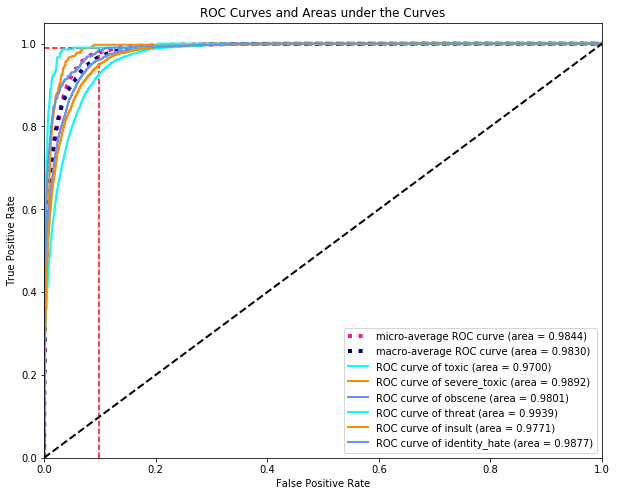

In [6]:
label, idx, thr, idx5, idx6 = plot_roc(y_test, y_pred)

In [7]:
# Calculate both positive (class=1) and negative (class=0) density
df = pd.DataFrame(np.column_stack([y_test, y_pred]))
pos_d=df[df[df.columns[idx]] ==1.0][df.columns[idx + 6]]
neg_d=df[df[df.columns[idx]] ==0.0][df.columns[idx + 6]]

/anaconda2/envs/toxic3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

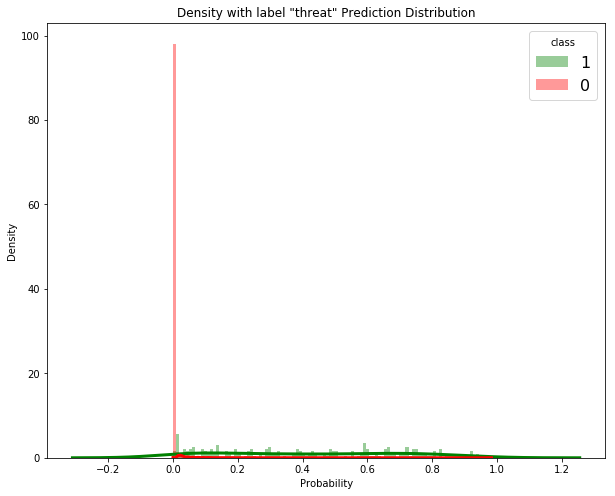

In [8]:
# Plot density distribution
# Define plot size
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,8))
sns.distplot(pos_d, hist = True, color='green', kde = True, bins=100,
                 kde_kws = {'linewidth': 3},
                 label = '1')
sns.distplot(neg_d, hist = True, color='red', kde = True, bins=100,
                 kde_kws = {'linewidth': 3},
                 label = '0')

# Plot formatting
plt.legend(prop={'size': 16}, title = 'class')
plt.title('Density with label "' + label + '" Prediction Distribution')
plt.xlabel('Probability')
plt.ylabel('Density')

In [9]:
# Generate classification report corresponding to cutoff at threshold value
from sklearn.metrics import classification_report
threshold = thr[idx][idx5]
#threshold = thr[idx][idx6]
print('Classification Report for label "{}" at threshold {:.4f}:'.format(label, threshold))
print(classification_report(y_test[:,idx], (y_pred[:,idx]>threshold).astype(int)))

Classification Report for label "threat" at threshold 0.4149:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.54      0.50      0.52       211

   micro avg       1.00      1.00      1.00     63978
   macro avg       0.77      0.75      0.76     63978
weighted avg       1.00      1.00      1.00     63978



In [10]:
# Calculate false positive rate corresponding to cutoff at threshold value
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test[:,idx], (y_pred[:,idx]>threshold).astype(int)).ravel()
print('True Positive Rate for label "{}" at threshold {:.4f}:'.format(label, threshold))
print("tpr: %.4f \n" % (tp/(fn+tp)))
print('False Positive Rate for label "{}" at threshold {:.4f}:'.format(label, threshold))
print("fpr: %.4f \n" % (fp/(tn+fp)))

True Positive Rate for label "threat" at threshold 0.4149:
tpr: 0.4976 

False Positive Rate for label "threat" at threshold 0.4149:
fpr: 0.0014 



In [11]:
# Generate multi label reports
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss

print("Label Ranking Average Precision (LRAP): %.6f" % (label_ranking_average_precision_score(y_test, y_pred)))
print("Label Ranking Loss (LRL): %.6f" % (label_ranking_loss(y_test, y_pred)))

Label Ranking Average Precision (LRAP): 0.997921
Label Ranking Loss (LRL): 0.001539


In [12]:
# Define clean_data function
import re
def clean_data(test):
    # Removing ip address
    X_test_clean = test["comment_text"].apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
    # Removing url link
    X_test_clean = X_test_clean.apply(lambda x: re.sub("http://.*com","",x))
    # Removing username
    X_test_clean = X_test_clean.apply(lambda x: re.sub("\[\[.*\]","",x))
    return X_test_clean

In [13]:
# Define sequencing function to convert test datasets into sequences
def sequencing(sentence):
    sentence = t.texts_to_sequences(sentence)
    x_sentence = sequence.pad_sequences(sentence, maxlen=maxlen)
    return x_sentence

In [14]:
# Filter out stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
def filter_stop_words(sentences, stop_words):
    filtered = []
    for sentence in sentences:
        words = sentence.split()
        words_filtered = [word for word in words if word not in stop_words]
        filtered.append(" ".join(words_filtered))
    return filtered

In [15]:
# Test smal changes in test dataset - with data cleaning and removing stopwords
# Clean data
X_test_clean = clean_data(test)
# Remove stop words
X_test_clean_no_stopwords = filter_stop_words(X_test_clean, stop_words)
# Convert test datasets into sequences
x_test_clean_no_stopwords = sequencing(X_test_clean_no_stopwords)
# Predict and calculate score
y_pred_clean_no_stopwords = model_saved.predict(x_test_clean_no_stopwords, batch_size=batch_size)
score = roc_auc_score(y_test, y_pred_clean_no_stopwords)
print("With data cleaning and removing stopwords:")
print("roc_auc score: %.6f \n" % (score))

With data cleaning and removing stopwords:
roc_auc score: 0.981417 



In [16]:
# Test smal changes in test dataset - data cleaning only
# Clean data
X_test_clean = clean_data(test)
# Remove stop words
#X_test_clean_no_stopwords = filter_stop_words(X_test_clean, stop_words)
# Convert test datasets into sequences
x_test_clean = sequencing(X_test_clean)
# Predict and calculate score
y_pred_clean = model_saved.predict(x_test_clean, batch_size=batch_size)
score = roc_auc_score(y_test, y_pred_clean)
print("Data cleaning only:")
print("roc_auc score: %.6f \n" % (score))

Data cleaning only:
roc_auc score: 0.982961 



In [17]:
# Test smal changes in test dataset - removing stopwords only
# Clean data
#X_test_clean = clean_data(test)
# Remove stop words
X_test_no_stopwords = filter_stop_words(test["comment_text"], stop_words)
# Convert test datasets into sequences
x_test_no_stopwords = sequencing(X_test_no_stopwords)
# Predict and calculate score
y_pred_no_stopwords = model_saved.predict(x_test_no_stopwords, batch_size=batch_size)
score = roc_auc_score(y_test, y_pred_no_stopwords)
print("Removing stopwords only:")
print("roc_auc score: %.6f \n" % (score))

Removing stopwords only:
roc_auc score: 0.981453 

